In [1]:
#Basic 
import numpy as np 
import pandas as pd
import collections

#Plotting 
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

#Regular modeling
import folium
import squarify
import matplotlib
import statsmodels.api as sm
from itertools import groupby
from operator import itemgetter
from math import sqrt

#Extended modeling
import matplotlib
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn import metrics, mixture, cluster, datasets
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA,SparsePCA,KernelPCA,NMF

from mlxtend.preprocessing import minmax_scaling

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
governors_path = "data/governors_county_candidate.csv"
president_path = "data/president_county_candidate.csv"
senate_path = "data/senate_county_candidate.csv"
census_path = "data/acs2017_county_data.csv"

In [3]:
df_governors = pd.read_csv(governors_path)
df_president = pd.read_csv(president_path)
df_senate = pd.read_csv(senate_path)

print("The number of rows for senate: " + format(df_senate.shape[0]) + ". The number of factors: " + format(df_senate.shape[1]))
print("The number of rows for president: " + format(df_president.shape[0]) + ". The number of factors: " + format(df_president.shape[1]))
print("The number of rows for governors: " + format(df_governors.shape[0]) + ". The number of factors: " + format(df_governors.shape[1]))

The number of rows for senate: 14125. The number of factors: 5
The number of rows for president: 32177. The number of factors: 6
The number of rows for governors: 5145. The number of factors: 6


In [4]:
df_president.head(5)

,state,county,candidate,party,total_votes,won
0,Delaware,Kent County,Joe Biden,DEM,44552,True
1,Delaware,Kent County,Donald Trump,REP,41009,False
2,Delaware,Kent County,Jo Jorgensen,LIB,1044,False
3,Delaware,Kent County,Howie Hawkins,GRN,420,False
4,Delaware,New Castle County,Joe Biden,DEM,195034,True


In [5]:
df_president_agg_REP  = df_president[(df_president.party=="REP")]
df_president_agg_DEM  = df_president[(df_president.party=="DEM")]
df_president_agg_REP = pd.DataFrame(df_president_agg_REP.groupby(["state", "county"])["total_votes"].sum())
df_president_agg_DEM = pd.DataFrame(df_president_agg_DEM.groupby(["state", "county"])["total_votes"].sum())
df_president_agg_REP = df_president_agg_REP.rename(columns={"total_votes": "votes REP president"})
df_president_agg_DEM = df_president_agg_DEM.rename(columns={"total_votes": "votes DEM president"})

df_president_agg = pd.merge(df_president_agg_DEM, df_president_agg_REP, on=["state", "county"], how="left")
df_president_agg.head(5)

votes DEM president  votes REP president
state   county                                                  
Alabama Autauga County                 7503                19838
        Baldwin County                24578                83544
        Barbour County                 4816                 5622
        Bibb County                    1986                 7525
        Blount County                  2640                24711

In [6]:
df_senate_agg_REP  = df_senate[(df_senate.party=="REP")]
df_senate_agg_DEM  = df_senate[(df_senate.party=="DEM")]
df_senate_agg_REP = pd.DataFrame(df_senate_agg_REP.groupby(["state", "county"])["total_votes"].sum())
df_senate_agg_DEM = pd.DataFrame(df_senate_agg_DEM.groupby(["state", "county"])["total_votes"].sum())
df_senate_agg_REP = df_senate_agg_REP.rename(columns={"total_votes": "votes REP senate"})
df_senate_agg_DEM = df_senate_agg_DEM.rename(columns={"total_votes": "votes DEM senate"})
df_senate_agg = pd.merge(df_senate_agg_DEM, df_senate_agg_REP, on=['state', 'county'],how='outer')

df_governors_agg_REP  = df_governors[(df_governors.party=="REP")]
df_governors_agg_DEM  = df_governors[(df_governors.party=="DEM")]
df_governors_agg_REP = pd.DataFrame(df_governors_agg_REP.groupby(["state", "county"])["votes"].sum())
df_governors_agg_DEM = pd.DataFrame(df_governors_agg_DEM.groupby(["state", "county"])["votes"].sum())
df_governors_agg_REP = df_governors_agg_REP.rename(columns={"votes": "votes REP governors"})
df_governors_agg_DEM = df_governors_agg_DEM.rename(columns={"votes": "votes DEM governors"})
df_governors_agg = pd.merge(df_governors_agg_DEM, df_governors_agg_REP, on=["state", "county"], how="outer")

df = pd.merge(df_president_agg, df_senate_agg, on=["state", "county"],how="left")
df = pd.merge(df, df_governors_agg, on=["state", "county"],how="left")
df = df.fillna(0)
df.head(5)

votes DEM president  votes REP president  \
state   county                                                     
Alabama Autauga County                 7503                19838   
        Baldwin County                24578                83544   
        Barbour County                 4816                 5622   
        Bibb County                    1986                 7525   
        Blount County                  2640                24711   

                        votes DEM senate  votes REP senate  \
state   county                                               
Alabama Autauga County            8277.0               0.0   
        Baldwin County           28925.0               0.0   
        Barbour County            5021.0               0.0   
        Bibb County               2244.0               0.0   
        Blount County             3290.0               0.0   

                        votes DEM governors  votes REP governors  
state   county                                                    
Alabama Autauga County                  0.0                  0.0  
        Baldwin County                  0.0                  0.0  
        Barbour County                  0.0                  0.0  
        Bibb County                     0.0                  0.0  
        Blount County                   0.0                  0.0

In [7]:
df_census = pd.read_csv(census_path)
df_census = df_census.rename(columns={"State": "state", "County": "county"})
df_census.head(5)

,CountyId,state,county,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,...,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2
1,1003,Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,...,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5
2,1005,Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,...,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4
3,1007,Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,...,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2
4,1009,Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,...,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9


In [8]:
vars_to_merge = [x for x in df_census.columns if x not in ["CountyId", "state", "county"]]

df_census_agg = pd.DataFrame(df_census.groupby(["state", "county"])[vars_to_merge].sum())
df_census_agg.head(5)

TotalPop    Men   Women  Hispanic  White  Black  \
state   county                                                            
Alabama Autauga County     55036  26899   28137       2.7   75.4   18.9   
        Baldwin County    203360  99527  103833       4.4   83.1    9.5   
        Barbour County     26201  13976   12225       4.2   45.7   47.8   
        Bibb County        22580  12251   10329       2.4   74.6   22.0   
        Blount County      57667  28490   29177       9.0   87.4    1.5   

                        Native  Asian  Pacific  VotingAgeCitizen  ...  Walk  \
state   county                                                    ...         
Alabama Autauga County     0.3    0.9      0.0             41016  ...   0.6   
        Baldwin County     0.8    0.7      0.0            155376  ...   0.8   
        Barbour County     0.2    0.6      0.0             20269  ...   2.2   
        Bibb County        0.4    0.0      0.0             17662  ...   0.3   
        Blount County      0.3    0.1      0.0             42513  ...   0.4   

                        OtherTransp  WorkAtHome  MeanCommute  Employed  \
state   county                                                           
Alabama Autauga County          1.3         2.5         25.8     24112   
        Baldwin County          1.1         5.6         27.0     89527   
        Barbour County          1.7         1.3         23.4      8878   
        Bibb County             1.7         1.5         30.0      8171   
        Blount County           0.4         2.1         35.0     21380   

                        PrivateWork  PublicWork  SelfEmployed  FamilyWork  \
state   county                                                              
Alabama Autauga County         74.1        20.2           5.6         0.1   
        Baldwin County         80.7        12.9           6.3         0.1   
        Barbour County         74.1        19.1           6.5         0.3   
        Bibb County            76.0        17.4           6.3         0.3   
        Blount County          83.9        11.9           4.0         0.1   

                        Unemployment  
state   county                        
Alabama Autauga County           5.2  
        Baldwin County           5.5  
        Barbour County          12.4  
        Bibb County              8.2  
        Blount County            4.9  

[5 rows x 34 columns]

In [9]:
df = pd.merge(df, df_census_agg, on=["state", "county"], how="left")

missing_percentage = (df.isnull().sum()).sum() / np.product(df.shape) * 100
print("The number of missing entries before cleaning: " + str(round(missing_percentage, 5)) + " %")

The number of missing entries before cleaning: 29.15282 %


In [10]:
df_null = df[df.isnull().any(axis=1)]
null_county = np.array(df_null.index.get_level_values("county"))
null_county

array(['ED 1', 'ED 10', 'ED 11', ..., 'Woodford', 'Woodstock',
       'Worcester'], dtype=object)

In [11]:
df["votes REP president perc"] = df["votes REP president"]  / (df["votes REP president"]+df["votes DEM president"])
df["votes DEM president perc"] = df["votes DEM president"]  / (df["votes REP president"]+df["votes DEM president"])
df["votes REP senate perc"] = df["votes REP senate"]  / (df["votes REP senate"]+df["votes DEM senate"])
df["votes DEM senate perc"] = df["votes DEM senate"]  / (df["votes REP president"]+df["votes DEM senate"])
df["votes REP governors perc"] = df["votes REP governors"]  / (df["votes REP governors"]+df["votes DEM governors"])
df["votes DEM governors perc"] = df["votes DEM governors"]  / (df["votes REP governors"]+df["votes DEM governors"])

votes_perc = df.iloc[:,-6:].columns
votes = [x for x in df.columns if x not in df_census_agg.columns]
factors = [x for x in df.columns if x not in votes]
df = df.fillna(0)

Missing_Percentage = (df.isnull().sum()).sum()/np.product(df.shape)*100
print("The number of missing entries before cleaning: " + str(round(Missing_Percentage,5)) + " %")

The number of missing entries before cleaning: 0.0 %


In [12]:
print("Number of rows: "+ format(df.shape[0]) +", number of features: "+ format(df.shape[1]))

Number of rows: 4633, number of features: 46


In [13]:
C = (df.dtypes == "object")
categorical_variables = list(C[C].index)

Integer = (df.dtypes == "int64") 
Float   = (df.dtypes == "float64") 
numeric_variables = list(Integer[Integer].index) + list(Float[Float].index)
print("Number of numeric variables: " + format(len(numeric_variables)) + ", number of categorical features: " + format(len(categorical_variables)))

Number of numeric variables: 46, number of categorical features: 0


In [14]:
df_final = minmax_scaling(df, columns=df.columns)
df_final

votes DEM president  votes REP president  \
state   county                                                        
Alabama Autauga County                0.002477             0.017318   
        Baldwin County                0.008115             0.072930   
        Barbour County                0.001590             0.004908   
        Bibb County                   0.000656             0.006569   
        Blount County                 0.000872             0.021572   
...                                        ...                  ...   
Wyoming Sweetwater County             0.001262             0.010675   
        Teton County                  0.003251             0.003790   
        Uinta County                  0.000525             0.006544   
        Washakie County               0.000215             0.002833   
        Weston County                 0.000119             0.002712   

                           votes DEM senate  votes REP senate  \
state   county                                                  
Alabama Autauga County             0.021644          0.000000   
        Baldwin County             0.075639          0.000000   
        Barbour County             0.013130          0.000000   
        Bibb County                0.005868          0.000000   
        Blount County              0.008603          0.000000   
...                                     ...               ...   
Wyoming Sweetwater County          0.010138          0.000000   
        Teton County               0.000000          0.005456   
        Uinta County               0.004176          0.000000   
        Washakie County            0.001723          0.000000   
        Weston County              0.001046          0.000000   

                           votes DEM governors  votes REP governors  TotalPop  \
state   county                                                                  
Alabama Autauga County                     0.0                  0.0  0.005446   
        Baldwin County                     0.0                  0.0  0.020123   
        Barbour County                     0.0                  0.0  0.002593   
        Bibb County                        0.0                  0.0  0.002234   
        Blount County                      0.0                  0.0  0.005706   
...                                        ...                  ...       ...   
Wyoming Sweetwater County                  0.0                  0.0  0.004406   
        Teton County                       0.0                  0.0  0.002268   
        Uinta County                       0.0                  0.0  0.002054   
        Washakie County                    0.0                  0.0  0.000817   
        Weston County                      0.0                  0.0  0.000704   

                                Men     Women  Hispanic  ...  PublicWork  \
state   county                                           ...               
Alabama Autauga County     0.005402  0.005489  0.027218  ...    0.311728   
        Baldwin County     0.019987  0.020256  0.044355  ...    0.199074   
        Barbour County     0.002807  0.002385  0.042339  ...    0.294753   
        Bibb County        0.002460  0.002015  0.024194  ...    0.268519   
        Blount County      0.005721  0.005692  0.090726  ...    0.183642   
...                             ...       ...       ...  ...         ...   
Wyoming Sweetwater County  0.004615  0.004203  0.161290  ...    0.274691   
        Teton County       0.002444  0.002098  0.151210  ...    0.175926   
        Uinta County       0.002127  0.001983  0.091734  ...    0.331790   
        Washakie County    0.000827  0.000807  0.143145  ...    0.339506   
        Weston County      0.000754  0.000656  0.014113  ...    0.337963   

                           SelfEmployed  FamilyWork  Unemployment  \
state   county                                                      
Alabama Autauga County         0.147368      0.0125      0.181185   
       

<AxesSubplot: >

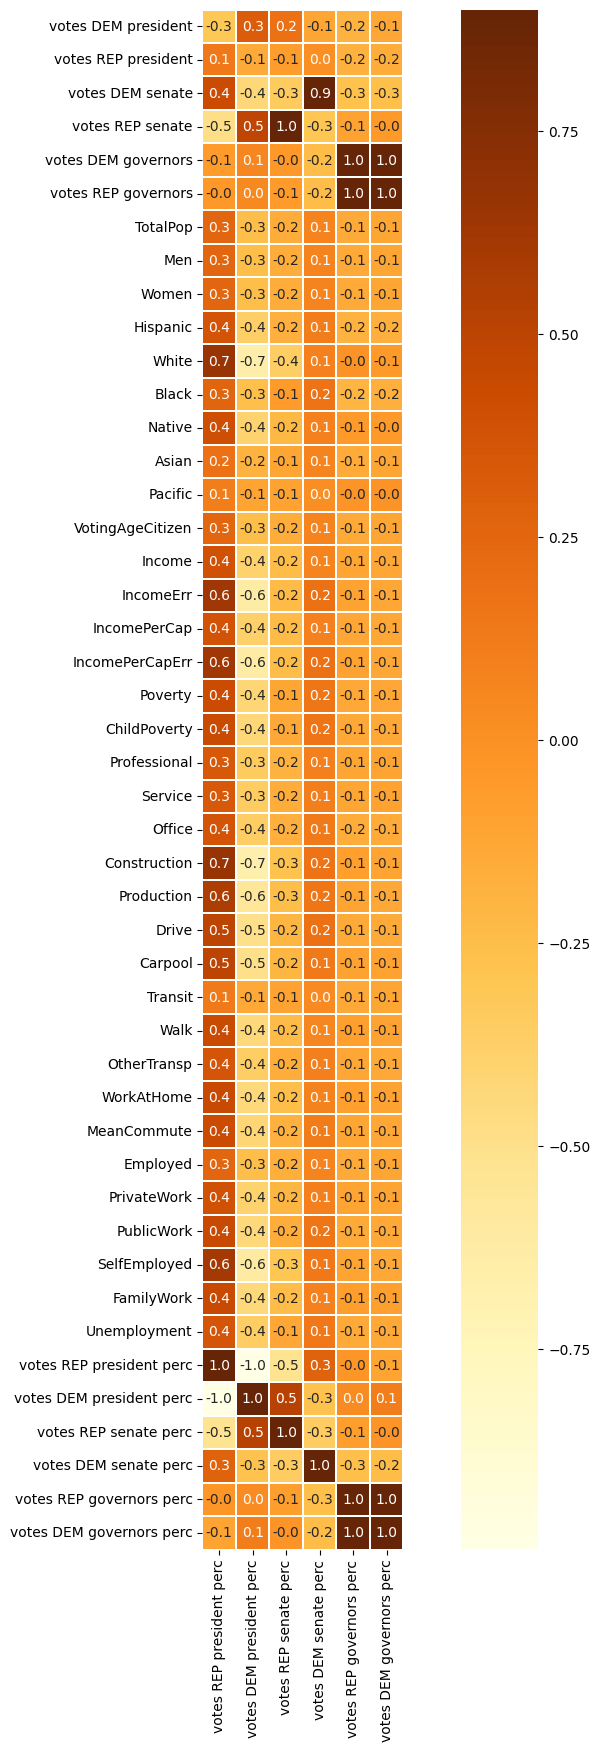

In [15]:
spearman_corr = df_final.corr(method="spearman")
x = spearman_corr[votes_perc]
plt.figure(figsize=(15, 20))
sns.heatmap(x, vmax=.9, square=True, annot=True, linewidths=.3, cmap="YlOrBr", fmt=".1f")

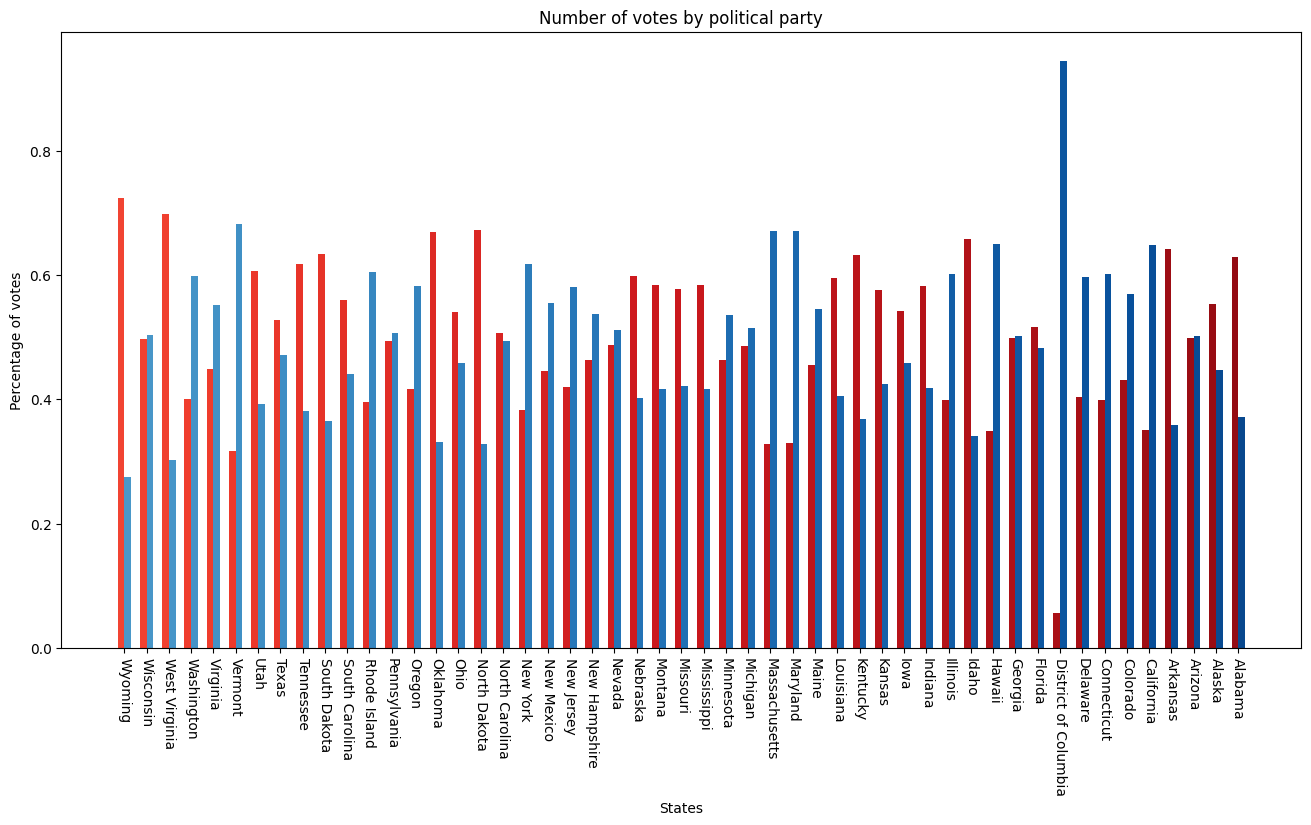

In [16]:
color_1 = plt.cm.Reds(np.linspace(0.6, 1, 66))
color_2 = plt.cm.Blues(np.linspace(0.6, 1, 66))

states = df.groupby("state").agg({"votes REP president": "sum","votes DEM president": "sum"}).sort_values(by="state", ascending=False)
states["Total votes"] = states["votes REP president"] + states["votes DEM president"]
states["votes REP president perc"] = states["votes REP president"] / states["Total votes"]
states["votes DEM president perc"] = states["votes DEM president"] / states["Total votes"]

data1 = states["votes REP president perc"]
data2 = states["votes DEM president perc"]

plt.figure(figsize=(16, 8))
x = np.arange(51)
ax1 = plt.subplot(1, 1, 1)
w = 0.3

color = color_1
plt.title("Number of votes by political party")
plt.xticks(x + w / 2, data1.index, rotation=-90)
ax1.set_xlabel("States")
ax1.set_ylabel("Percentage of votes")
ax1.bar(x, data1.values, color=color_1, width=w, align="center")

color = color_2
ax2 = ax1
ax2.bar(x + w, data2, color=color_2, width=w, align="center")

plt.show()

Text(0.5, 21.433333333333326, 'n_components')

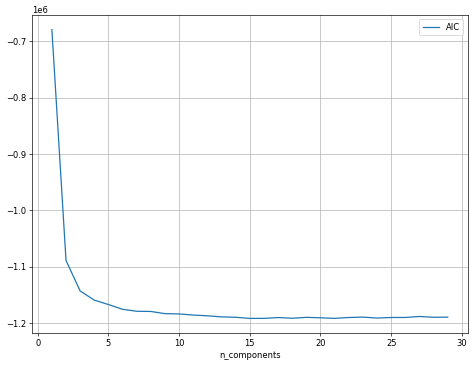

In [17]:
x = df_final[factors].values

gm_n_components = np.arange(1, 30)
gm_models = [mixture.GaussianMixture(n, covariance_type="full", random_state=0).fit(x) for n in gm_n_components]

plt.figure(num=None, figsize=(8, 6), dpi=60, facecolor="w", edgecolor="r")
plt.plot(gm_n_components, [m.aic(x) for m in gm_models], label="AIC")
plt.tight_layout()
plt.legend(loc="best")
plt.grid()
plt.xlabel("n_components")

In [18]:
gm_n_classes = 2

gm_cluster = mixture.GaussianMixture(n_components=gm_n_classes, covariance_type="full", random_state=0)
gm_cluster_fit = gm_cluster.fit(df_final)
gm_labels = gm_cluster_fit.predict(df_final)

print("Number of clusters: " + format(len(np.unique(gm_labels))))

Number of clusters: 2


In [19]:
unique, counts = np.unique(gm_labels, return_counts=True)
dict(zip(unique, counts))

{0: 3044, 1: 1589}

In [20]:
df_final["Party_Cluster"] = gm_labels

In [21]:
df_final

votes DEM president  votes REP president  \
state   county                                                        
Alabama Autauga County                0.002477             0.017318   
        Baldwin County                0.008115             0.072930   
        Barbour County                0.001590             0.004908   
        Bibb County                   0.000656             0.006569   
        Blount County                 0.000872             0.021572   
...                                        ...                  ...   
Wyoming Sweetwater County             0.001262             0.010675   
        Teton County                  0.003251             0.003790   
        Uinta County                  0.000525             0.006544   
        Washakie County               0.000215             0.002833   
        Weston County                 0.000119             0.002712   

                           votes DEM senate  votes REP senate  \
state   county                                                  
Alabama Autauga County             0.021644          0.000000   
        Baldwin County             0.075639          0.000000   
        Barbour County             0.013130          0.000000   
        Bibb County                0.005868          0.000000   
        Blount County              0.008603          0.000000   
...                                     ...               ...   
Wyoming Sweetwater County          0.010138          0.000000   
        Teton County               0.000000          0.005456   
        Uinta County               0.004176          0.000000   
        Washakie County            0.001723          0.000000   
        Weston County              0.001046          0.000000   

                           votes DEM governors  votes REP governors  TotalPop  \
state   county                                                                  
Alabama Autauga County                     0.0                  0.0  0.005446   
        Baldwin County                     0.0                  0.0  0.020123   
        Barbour County                     0.0                  0.0  0.002593   
        Bibb County                        0.0                  0.0  0.002234   
        Blount County                      0.0                  0.0  0.005706   
...                                        ...                  ...       ...   
Wyoming Sweetwater County                  0.0                  0.0  0.004406   
        Teton County                       0.0                  0.0  0.002268   
        Uinta County                       0.0                  0.0  0.002054   
        Washakie County                    0.0                  0.0  0.000817   
        Weston County                      0.0                  0.0  0.000704   

                                Men     Women  Hispanic  ...  SelfEmployed  \
state   county                                           ...                 
Alabama Autauga County     0.005402  0.005489  0.027218  ...      0.147368   
        Baldwin County     0.019987  0.020256  0.044355  ...      0.165789   
        Barbour County     0.002807  0.002385  0.042339  ...      0.171053   
        Bibb County        0.002460  0.002015  0.024194  ...      0.165789   
        Blount County      0.005721  0.005692  0.090726  ...      0.105263   
...                             ...       ...       ...  ...           ...   
Wyoming Sweetwater County  0.004615  0.004203  0.161290  ...      0.100000   
        Teton County       0.002444  0.002098  0.151210  ...      0.171053   
        Uinta County       0.002127  0.001983  0.091734  ...      0.173684   
        Washakie County    0.000827  0.000807  0.143145  ...      0.213158   
        Weston County      0.000754  0.000656  0.014113  ...      0.231579   

                           FamilyWork  Unemployment  votes REP president perc  \
state   county                                                                  
Alabama Autauga County    

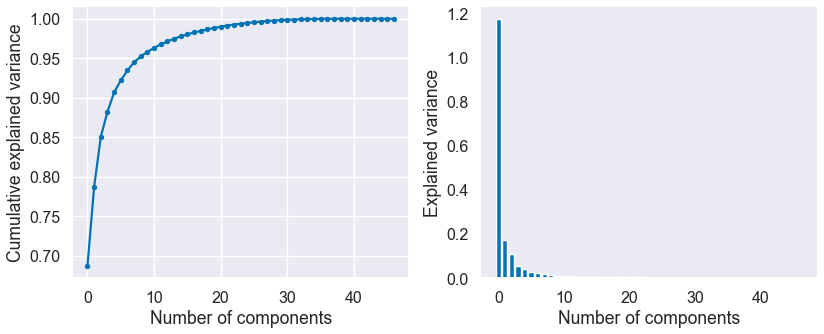

In [23]:
pca = PCA().fit(df_final)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=70, facecolor="w", edgecolor="k")
ax0, ax1 = axes.flatten()

sns.set("talk", palette="colorblind")

font = {"family" : "sans serif",
        "size"   : 14}

matplotlib.rc("font", **font)

ax0.plot(np.cumsum(pca.explained_variance_ratio_), marker=".")
ax0.set_xlabel("Number of components")
ax0.set_ylabel("Cumulative explained variance")

ax1.bar(range(df_final.shape[1]),pca.explained_variance_)
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Explained variance")

plt.tight_layout()
plt.grid()
plt.show()

In [24]:
n_pca_90 = np.size(np.cumsum(pca.explained_variance_ratio_) > 0.9) - np.count_nonzero(np.cumsum(pca.explained_variance_ratio_) > 0.9)
print("Already: " + format(n_pca_90) + " components cover 90% of variance.")

Already: 4 components cover 90% of variance.


C:\Users\Thanh_Tuyet\AppData\Local\Temp\ipykernel_9208\2660473434.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


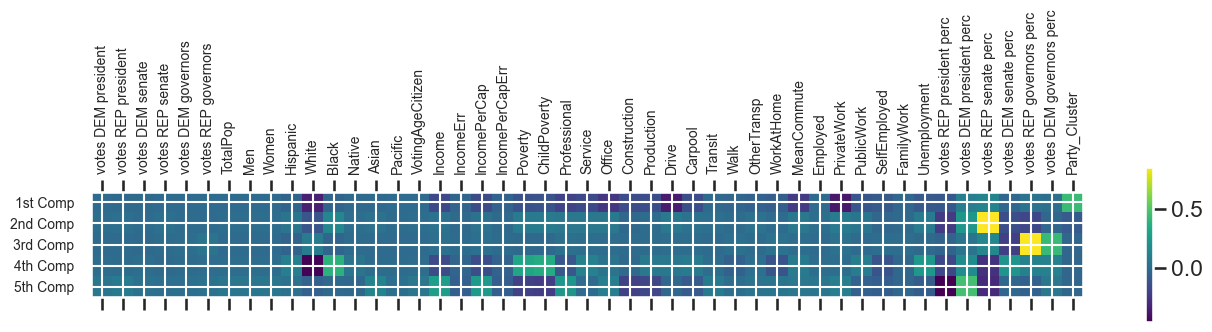

In [25]:
pca = PCA(5).fit(df_final)

x_pca = pca.transform(df_final) 

plt.matshow(pca.components_, cmap="viridis")
plt.yticks([0, 1, 2, 3, 4], ["1st Comp", "2nd Comp", "3rd Comp", "4th Comp", "5th Comp"], fontsize=10)
plt.colorbar()
plt.xticks(range(len(df_final.columns)), df_final.columns, fontsize=10, rotation=90)
plt.tight_layout()
plt.show()

In [26]:
pca_vars = [0] * len(df_final.columns)

def extract_column(lst, j): 
    return [item[j] for item in lst] 

for i, feature in zip(range(len(df_final.columns)), df_final.columns):
    x = extract_column(pca.components_, i)
    if ((max(x) > 0.2) | (min(x) < -0.2)):
        if abs(max(x)) > abs(min(x)):
            pca_vars[i] = max(x)
        else:
            pca_vars[i] = min(x)                 
    else:
        pca_vars[i] = 0

pca_vars = pd.DataFrame(list(zip(df_final.columns, pca_vars)), columns=("Name", "Max absolute contribution"), index=range(1, 48, 1))      
pca_vars = (pca_vars[(pca_vars["Max absolute contribution"] != 0)]).sort_values(by="Max absolute contribution", ascending=False)
pca_vars

,Name,Max absolute contribution
43,votes REP senate perc,0.856189
45,votes REP governors perc,0.850426
42,votes DEM president perc,0.462695
47,Party_Cluster,0.436682
46,votes DEM governors perc,0.431561
12,Black,0.383559
22,ChildPoverty,0.347358
21,Poverty,0.319953
17,Income,0.269874
19,IncomePerCap,0.244619


In [28]:
df_final_estimation = df_final.drop(null_county, level="county")

response = pd.DataFrame(df_final_estimation["votes REP president perc"] + df_final_estimation["votes REP senate perc"] + df_final_estimation["votes REP governors perc"],columns=["Response"])
response = minmax_scaling(response, columns=response.columns)
#df_final["ResponseDEM"] = df_final["votes DEM president perc"] + df_final["votes DEM senate perc"] + df_final["votes DEM governors perc"]

df_final_estimation = df_final_estimation.drop(votes, axis=1)

x_train, x_test, y_train, y_test = train_test_split(df_final_estimation, response, test_size=0.2, random_state=0)


In [30]:
model_average = y_train.mean()
print(str(round(model_average, 5)))

Response    0.44429
dtype: float64


In [33]:
rmse = y_test
rmse.insert(1, "Model_Average", model_average.values[0], True)
y_test=y_test.drop(["Model_Average"], axis=1)
rmse.head(5)

,,Response,Model_Average
state,county,,
Georgia,Morgan County,0.530673,0.44429
Nebraska,Dixon County,0.376405,0.44429
Oklahoma,Grant County,0.422466,0.44429
Utah,Tooele County,0.717632,0.44429
Texas,Menard County,0.389067,0.44429


In [34]:
model_glm = sm.GLM(y_train, x_train, family=sm.families.Gaussian())

model_glm_fit = model_glm.fit()

print(model_glm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Response   No. Observations:                 2435
Model:                            GLM   Df Residuals:                     2402
Model Family:                Gaussian   Df Model:                           32
Link Function:               identity   Scale:                        0.031805
Method:                          IRLS   Log-Likelihood:                 759.60
Date:                Tue, 31 Jan 2023   Deviance:                       76.395
Time:                        13:29:24   Pearson chi2:                     76.4
No. Iterations:                   100   Pseudo R-squ. (CS):            0.07974
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
TotalPop             0.5672      0.864  

In [35]:
rmse.insert(2, "Model_GLM", model_glm_fit.predict(x_test).values, True)

In [40]:
np.sqrt(np.mean((rmse["Response"] - rmse["Model_GLM"])**2))

0.1788442359772182

In [41]:
space={"max_depth": hp.quniform("max_depth", 2,25,1),
      "alpha": hp.uniform ("alpha", 0,1),
      "colsample_bytree" : hp.uniform("colsample_bytree", 0.5,1),
      "min_child_weight" : hp.quniform("min_child_weight", 0, 25, 1),
      "learning_rate" : hp.uniform("learning_rate", 0.00001, 0.8),
      "n_estimators": 500,
      "seed": 0}

def f_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions - targets) ** 2))

def objective(space):
    clf = xgb.XGBRegressor(objective ="reg:squarederror",n_estimators =space["n_estimators"], max_depth=int(space["max_depth"]), alpha=space["alpha"],
                           learning_rate = space["learning_rate"],min_child_weight=space["min_child_weight"],colsample_bytree=space["colsample_bytree"])

    evaluation = [(x_train, y_train), (x_test, y_test)]
    
    clf_fit = clf.fit(x_train, y_train, verbose=False, eval_set=evaluation, early_stopping_rounds=20)
    
    pred = clf_fit.predict(x_test)
    score = f_rmse(rmse["Response"].values, pred)
    print(format(score))
    return {"loss": score, "status": STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



0.1736680499653786                                     
0.16890129430061263                                                              
0.16599594832921427                                                               
0.17292538629870952                                                               
0.1710508358114221                                                                
0.16569710269321297                                                               
0.17911659160084556                                                               
0.17471168185319216                                                               
0.17710500569759008                                                               
0.17067376004413007                                                               
0.17306089444743356                                                                
0.16953393249687176                                                                
0.17476754331269662           

In [42]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'alpha': 0.5775903472536544, 'colsample_bytree': 0.7729754245322459, 'learning_rate': 0.06659456176652384, 'max_depth': 21.0, 'min_child_weight': 9.0}


In [43]:
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree=0.7046466436203225, learning_rate=0.02192155309970599,
                             max_depth=16, alpha=0.4135415520098815, n_estimators=300, min_child_weight=14)

model_xgb_fit = model_xgb.fit(x_train, y_train)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

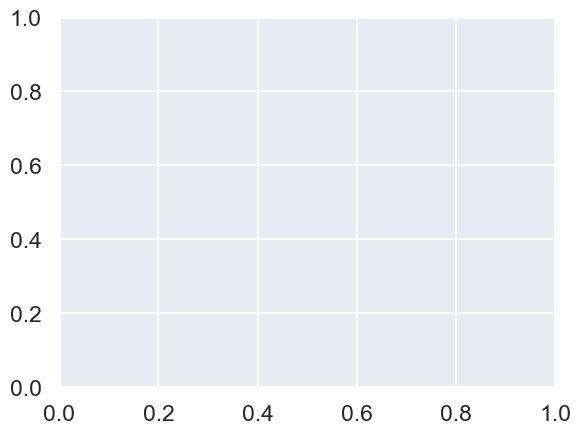

In [44]:
xgb.plot_tree(model_xgb_fit,num_trees=0)
plt.rcParams['figure.figsize'] = [80,50]
plt.show()

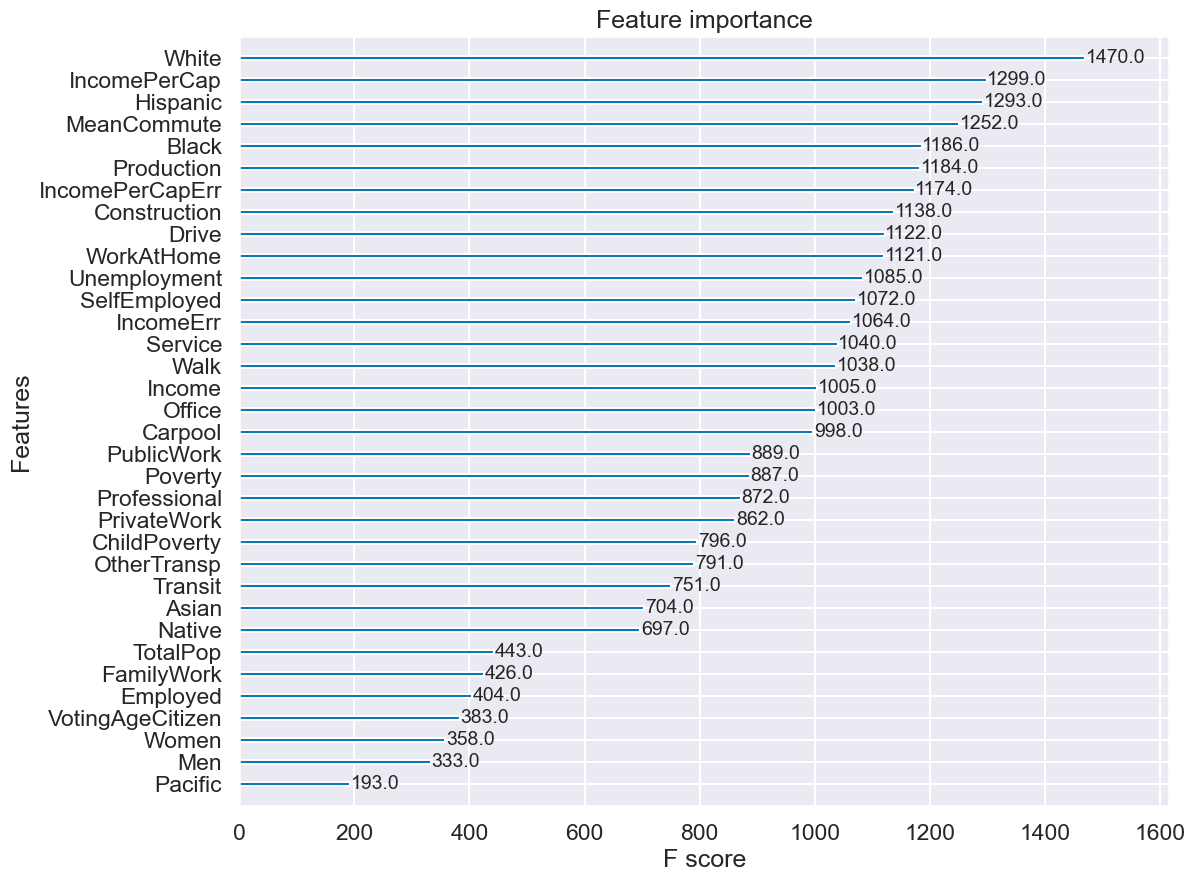

In [46]:
xgb.plot_importance(model_xgb_fit)
plt.rcParams['figure.figsize'] = [24, 20]
plt.show()

In [47]:
rmse.insert(3, 'Model_XGB', model_xgb_fit.predict(x_test), True)
rmse.head(5)

,,Response,Model_Average,Model_GLM,Model_XGB
state,county,,,,
Georgia,Morgan County,0.530673,0.44429,0.496314,0.392354
Nebraska,Dixon County,0.376405,0.44429,0.432099,0.404330
Oklahoma,Grant County,0.422466,0.44429,0.402209,0.391335
Utah,Tooele County,0.717632,0.44429,0.465075,0.653223
Texas,Menard County,0.389067,0.44429,0.498045,0.374189


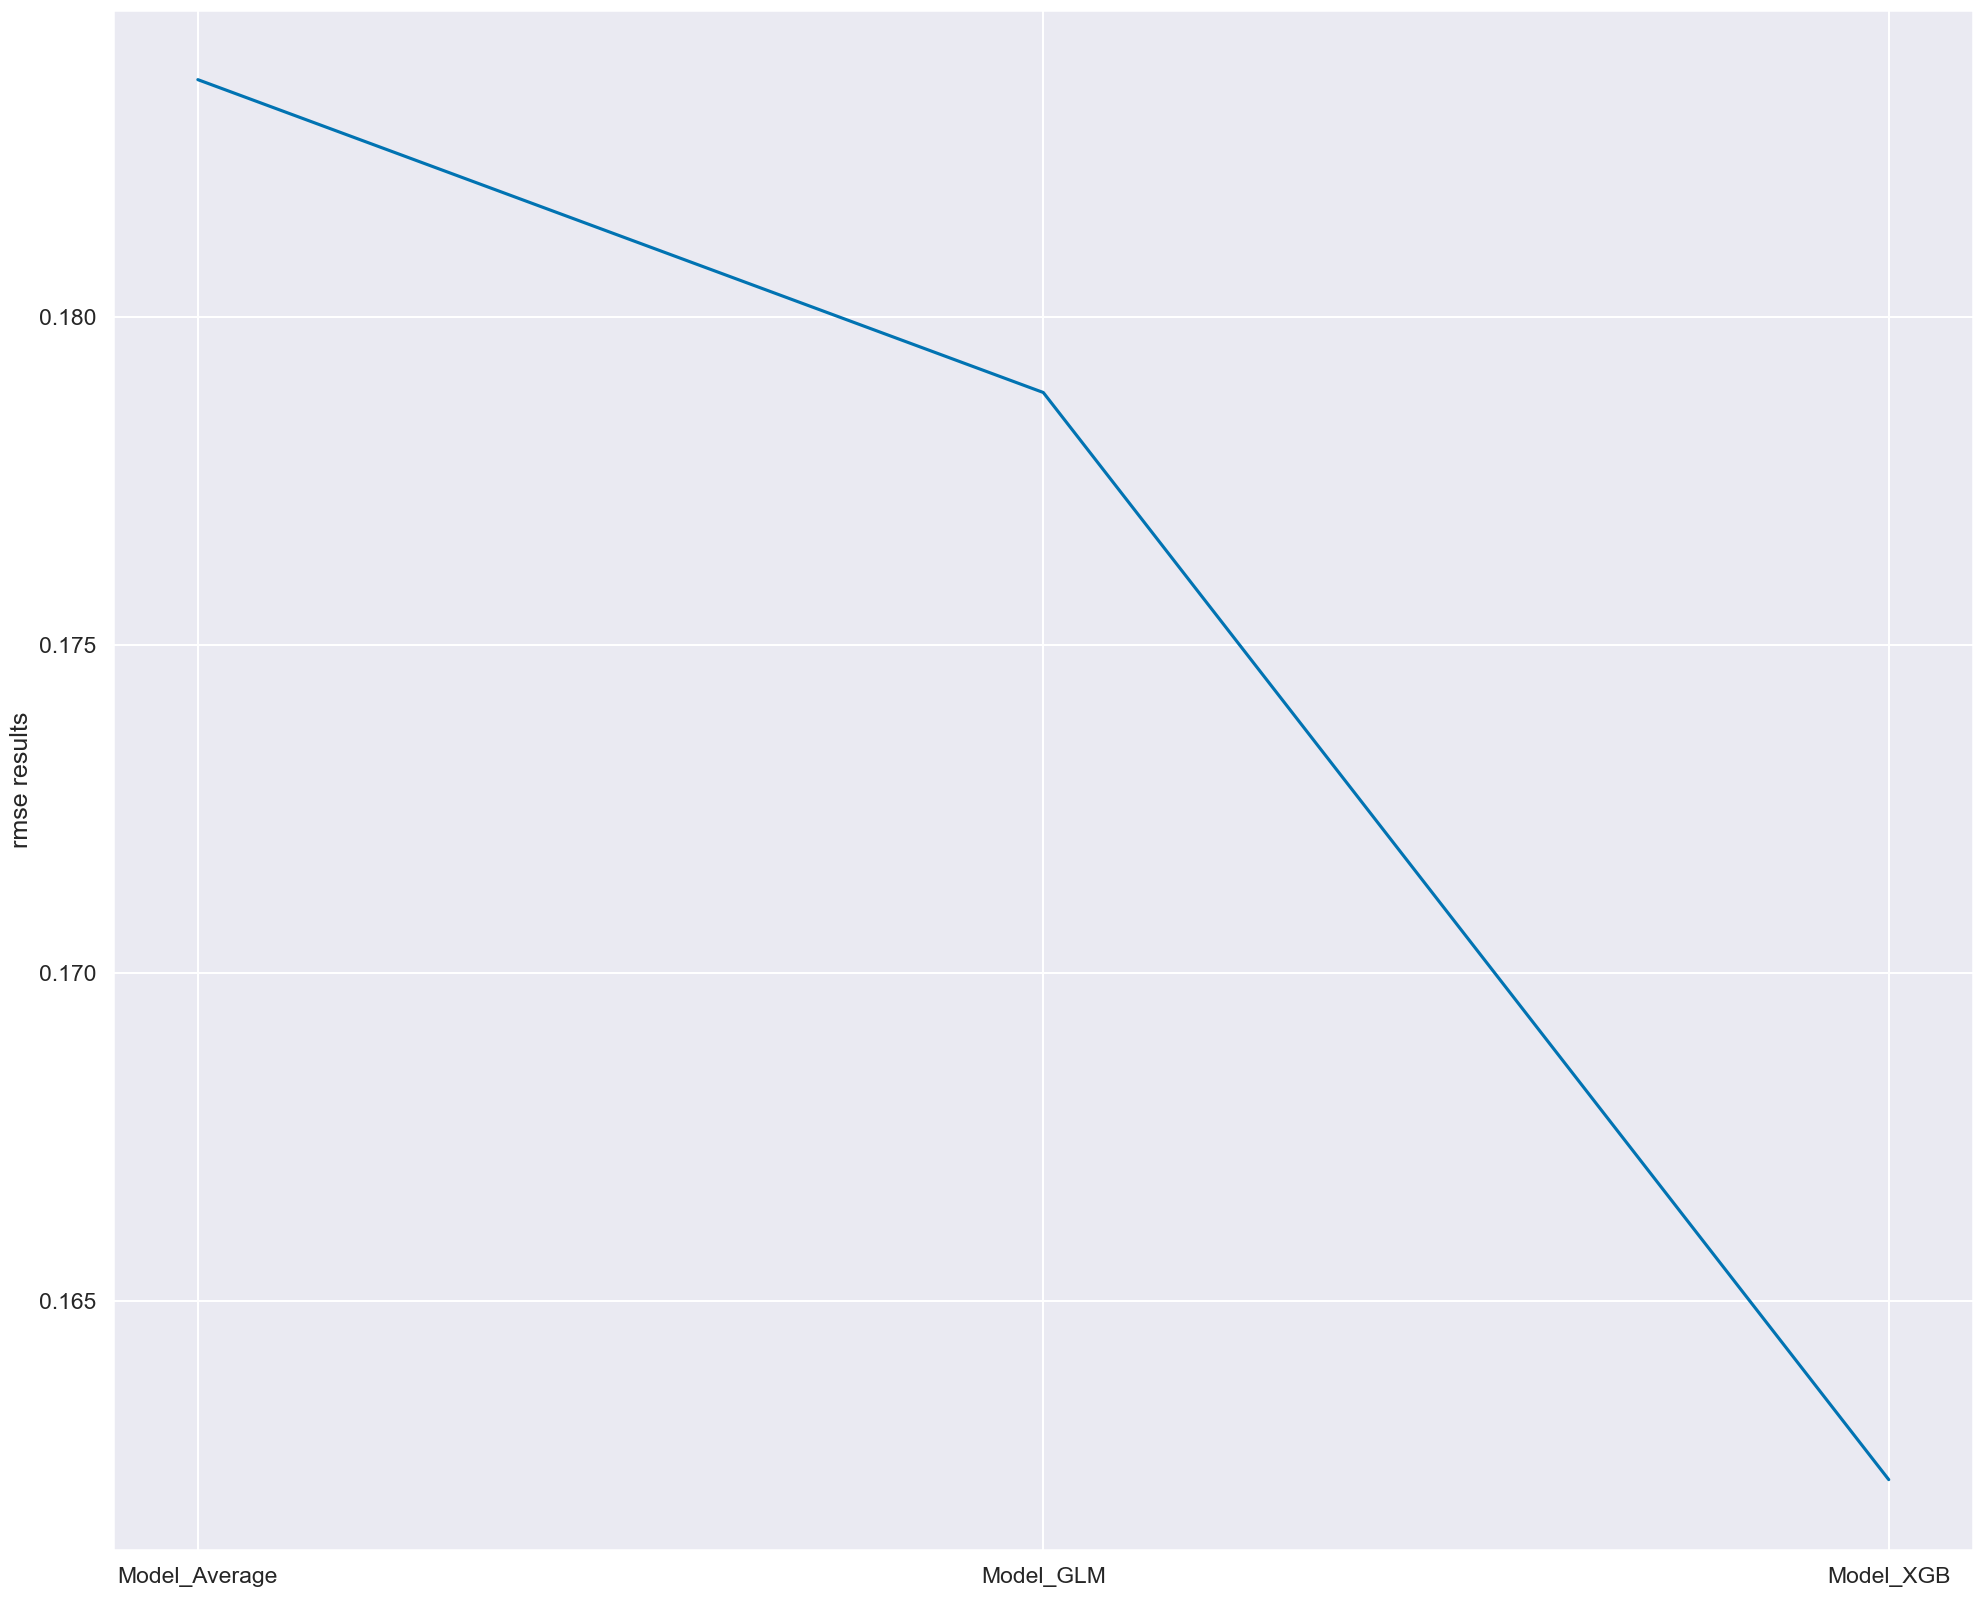

In [48]:
model_average_rmse = f_rmse(rmse["Response"].values, rmse["Model_Average"].values)   
model_glm_rmse = f_rmse(rmse["Response"].values, rmse["Model_GLM"].values)    
model_xgb_rmse = f_rmse(rmse["Response"].values, rmse["Model_XGB"].values)  

Results = pd.DataFrame({"rmse": [model_average_rmse,model_glm_rmse,model_xgb_rmse],"Name": ["Model_Average","Model_GLM","Model_XGB"]})
Results = Results.set_index("Name")

plt.plot(Results)
plt.ylabel("rmse results")
plt.show()